# Measure mutual information between aligned residue pairs for 3Di, CLE and 3D-BLAST

In [ ]:
!mkdir tmp
!awk '{print $1,$2,$10}' data/tmaln-06.out > tmp/pairfile.csv
!curl https://wwwuser.gwdg.de/~compbiol/foldseek/scp40pdb.tar.gz | tar -xz
!mv pdb tmp/

## CLE

In [ ]:
!git clone https://github.com/realbigws/PDB_Tool.git tmp/PDB_Tool
!cd tmp/PDB_Tool/source_code/ && make

In [ ]:
!mkdir tmp/cle_output
!awk '{print $1,"_",$1}' tmp/pdbs.txt > tmp/pdbs_cle.txt

In [ ]:
!tmp/PDB_Tool/PDB_Tool -i tmp/pdbs/  -L tmp/pdbs_cle.txt -o tmp/cle_output -F 1

In [ ]:
!cat tmp/cle_output/*.cle > tmp/cle.fasta
!awk '/^>/{printf "%s ", substr($1,2,7)} /^[^>]/{print $0}' tmp/cle.fasta > tmp/cle.csv

## 3Di

In [ ]:
!foldseek createdb tmp/pdbs/ tmp/3Di
!mv tmp/3Di_ss tmp/3Di # HACK
!foldseek convert2fasta tmp/3Di tmp/3di.fasta
!awk '/^>/{printf "%s ", substr($1,2,7)} /^[^>]/{print $0}' tmp/3di.fasta > tmp/3di.csv

## 3D-blast

In [ ]:
!curl http://3d-blast.life.nctu.edu.tw/Standalone_3d-blast_Linux_beta102.tar.gz | tar -xz
!mv Standalone_3d-blast_Linux_beta102 tmp/Standalone_3d-blast_Linux
!cd tmp/Standalone_3d-blast_Linux && make

**Need to apply this patch to 3d-blast.c !**
This inserts an extra letter for invalid residues instead of skipping the residue (which would cause different sequence lenghts in comparison to the other tools)

In [ ]:
%%writefile missing_states.patch

diff --git a/3d-blast.c b/3d-blast.c.new
index 4d90845..ba40dc3 100644
--- a/3d-blast.c
+++ b/3d-blast.c.new
@@ -132,7 +132,7 @@ void SAcoding(string protein,char chain,COMMANDS Commands)
 	char ftmp[7];
 	float kappa, kappa_tmp, alpha, alpha_tmp;
 	char coding[18][36];
-	char SA_coding_rule[648];
+	char SA_coding_rule[650];  // prev 648
 	char output[1];
 	int flag_tempdssp=0;
 	string file_tempdssp;
@@ -199,7 +199,7 @@ void SAcoding(string protein,char chain,COMMANDS Commands)
             alpha=floor((alpha+180)/10);
 
             if (kappa>18 || alpha>36)
-				continue;
+                output[0] = 'J';  // prev continue;
 		    else
 		    {
 		    	output[0]=coding[(int)kappa][(int)alpha];


In [ ]:
!find tmp/pdb/ -type f -name 'd*' -exec mv -- {} {}".pdb" \;

In [ ]:
!for pdb in tmp/pdb/d*; do CHAIN=$(head -n 1 $pdb | awk '{print $5}'); tmp/Standalone_3d-blast_Linux/3d-blast -sq_append $pdb $CHAIN -o tmp/3dblast.fasta &> /dev/null; done

In [ ]:
!awk '/^>/{printf "%s ", substr($0,14,7)} /^[^>]/{print $0}' tmp/3dblast.fasta > tmp/3dblast.csv

## Measure mutual information

In [ ]:
!../create_submat.py tmp/pairfile.csv tmp/3di.csv

    A   C  D   E  F  G  H   I   K   L   M   N  P   Q  R   S   T   V   W   Y
A   6  -3  1   2  3 -2 -2  -7  -3  -3 -10  -5 -1   1 -4  -7  -5  -6   0  -2
C  -3   6 -2  -8 -5 -4 -4 -12 -13   1 -14   0  0   1 -1   0  -8   1  -7  -9
D   1  -2  4  -3  0  1  1  -3  -4  -4  -5  -2  1  -1 -1  -4  -2  -3  -2  -2
E   2  -8 -3   9 -2 -7 -4 -12 -10  -7 -17  -8 -6  -3 -8 -10 -10 -13  -6  -3
F   3  -5  0  -2  7 -3 -3  -5   1  -3  -9  -5 -2   2 -5  -8  -3  -7   4  -4
G  -2  -4  1  -7 -3  6  3   0  -7  -7  -1  -2 -2  -4  3  -3   4  -6  -4  -2
H  -2  -4  1  -4 -3  3  6  -4  -7  -6  -6   0 -1  -3  1  -3  -1  -5  -5   3
I  -7 -12 -3 -12 -5  0 -4   8  -5 -11   7  -7 -6  -6 -3  -9   6 -12  -5  -8
K  -3 -13 -4 -10  1 -7 -7  -5   9 -11  -8 -12 -7  -5 -9 -14  -5 -15   5  -8
L  -3   1 -4  -7 -3 -7 -6 -11 -11   6 -16  -3 -2   2 -4  -4  -9   0  -8  -9
M -10 -14 -5 -17 -9 -1 -6   7  -8 -16  10  -9 -9 -10 -5 -10   3 -16  -6  -9
N  -5   0 -2  -8 -5 -2  0  -7 -12  -3  -9   7  0  -2  2   3  -4   0  -8  -5
P  -1   0  1

In [ ]:
!../create_submat.py tmp/pairfile.csv tmp/cle.csv

   A  B  C   D   E  F  G   H  I  J  K  L  M  N  O  P  Q  R
A  7  1  1  -3  -4 -3 -2  -5 -3 -3 -2 -2 -1  0  2  3  1  0
B  1  6  0   1   1  0  0  -8 -5 -4 -4 -1 -1 -2 -1  4  0  0
C  1  0  5   2  -1  2 -1  -7 -5 -4 -3 -1 -2 -1 -1 -1  2  1
D -3  1  2   5   2  1 -3 -11 -9 -7 -6 -2 -4 -4 -4 -2  1 -1
E -4  1 -1   2   4  2 -2 -11 -9 -7 -7 -2 -5 -4 -5 -2 -1 -1
F -3  0  2   1   2  5 -1  -8 -7 -6 -5 -1 -3 -3 -3 -1  0  0
G -2  0 -1  -3  -2 -1  6  -5 -3 -2 -1  2  2 -2 -1  0  0  0
H -5 -8 -7 -11 -11 -8 -5   3  2  1  0 -6 -1 -4 -5 -5 -8 -3
I -3 -5 -5  -9  -9 -7 -3   2  3  2  2 -4  0 -1 -2 -4 -5 -2
J -3 -4 -4  -7  -7 -6 -2   1  2  5  1 -3  1 -1 -2 -3 -3 -1
K -2 -4 -3  -6  -7 -5 -1   0  2  1  6  0  1  3  0 -3 -2 -1
L -2 -1 -1  -2  -2 -1  2  -6 -4 -3  0  7  0  0 -1 -2  2  0
M -1 -1 -2  -4  -5 -3  2  -1  0  1  1  0  7  0  0  1 -1  0
N  0 -2 -1  -4  -4 -3 -2  -4 -1 -1  3  0  0  8  2 -2  2  0
O  2 -1 -1  -4  -5 -3 -1  -5 -2 -2  0 -1  0  2  9  0 -1 -1
P  3  4 -1  -2  -2 -1  0  -5 -4 -3 -3 -2  1 -2  0  7 -1 

In [ ]:
!../create_submat.py tmp/pairfile.csv tmp/3dblast.csv 2> tmp/err.txt && wc -l err.txt

    A   B   C   D   E   F  G   H  I  J  K  ...  N  P  Q  R  S  T  V   W  X   Y   Z
A   4   2   3   3 -12 -10  0  -9 -1 -3 -8  ... -7 -6 -2 -5 -4 -6 -6  -4 -6   3  -6
B   2   4   3   3 -12 -10  1  -9 -1 -2 -7  ... -7 -6 -2 -4 -4 -6 -5  -5 -6   3  -6
C   3   3   4   2 -12  -9  0  -9  2 -3 -7  ... -7 -6 -2 -5 -4 -6 -6  -4 -6   3  -6
D   3   3   2   3 -10  -9  2  -8  0 -2 -6  ... -6 -5 -1 -3 -3 -5 -3  -1 -4   2  -5
E -12 -12 -12 -10   5   3 -7   3 -8 -2 -1  ...  0 -2 -7 -5 -8 -4 -4  -6 -2 -13  -2
F -10 -10  -9  -9   3   5 -6   1 -7  0  3  ...  0 -2 -5 -4 -6 -2 -3  -4 -2 -10  -1
G   0   1   0   2  -7  -6  5  -5  1 -1 -3  ... -3 -3  2 -1 -2 -2  0  -1 -1   0  -3
H  -9  -9  -9  -8   3   1 -5   5 -6 -1  0  ...  2 -1 -4 -1 -5 -2 -3  -3  1 -10   0
I  -1  -1   2   0  -8  -7  1  -6  9 -1 -4  ... -4 -3  0 -1 -1 -3 -2   3 -3  -2   0
J  -3  -2  -3  -2  -2   0 -1  -1 -1  8  1  ...  0  0  0  0 -1  0  0  -1  0  -3   0
K  -8  -7  -7  -6  -1   3 -3   0 -4  1  5  ...  2 -1 -3 -3 -3  1  0  -3  0  -8   1
L   

# Plot

In [ ]:
import matplotlib.pyplot as plt

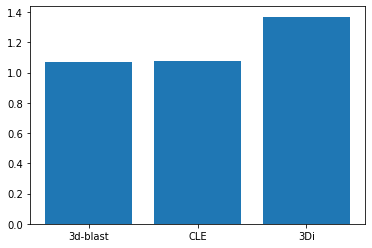

In [ ]:
plt.bar(['3d-blast', 'CLE', '3Di'], [1.07, 1.08, 1.37])
plt.show()